In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "DRWP5"
station_dv = "DRWP-RL5 (Pa)"
station_path = "data/station_inputs/drwp_rl5_for_maps.csv"
input_model_path = "data/model_inputs/drwp_CanRCM4-LE_ens15_1951-2016_rl5_ensmean.nc"
medians = {"value": 163, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = False


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,Cli_ID,station_name,lat,lon,elev (m),DRWP-RL5 (Pa),rlat,rlon,model_values,ratio
0,558,1009,6139527,WINDSOR A,42.28,-82.96,190,179.16,-4.283104,10.369387,227.871414,0.948826
1,576,1017,6127514,SARNIA AIRPORT,42.99,-82.30,181,143.06,-3.496103,10.717288,237.003296,0.728449
2,580,1035,6144473,LONDON INT'L AIRPORT,43.03,-81.15,278,131.57,-3.293246,11.535783,273.185791,0.581211


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

29.385

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/129 [00:00<?, ?it/s]

  2%|▏         | 2/129 [00:02<03:01,  1.43s/it]

  2%|▏         | 3/129 [00:05<03:45,  1.79s/it]

  3%|▎         | 4/129 [00:07<03:35,  1.72s/it]

  4%|▍         | 5/129 [00:08<03:24,  1.65s/it]

  5%|▍         | 6/129 [00:10<03:17,  1.61s/it]

  5%|▌         | 7/129 [00:11<03:15,  1.60s/it]

  6%|▌         | 8/129 [00:13<03:06,  1.54s/it]

  7%|▋         | 9/129 [00:14<02:58,  1.49s/it]

  8%|▊         | 10/129 [00:16<03:33,  1.79s/it]

  9%|▊         | 11/129 [00:19<03:46,  1.92s/it]

  9%|▉         | 12/129 [00:20<03:17,  1.69s/it]

 10%|█         | 13/129 [00:22<03:18,  1.71s/it]

 11%|█         | 14/129 [00:24<03:30,  1.83s/it]

 12%|█▏        | 15/129 [00:25<03:11,  1.68s/it]

 12%|█▏        | 16/129 [00:26<02:58,  1.58s/it]

 13%|█▎        | 17/129 [00:28<02:50,  1.52s/it]

 14%|█▍        | 18/129 [00:29<02:54,  1.58s/it]

 15%|█▍        | 19/129 [00:31<02:52,  1.57s/it]

 16%|█▌        | 20/129 [00:33<03:16,  1.81s/it]

 16%|█▋        | 21/129 [00:35<03:19,  1.85s/it]

 17%|█▋        | 22/129 [00:37<03:27,  1.94s/it]

 18%|█▊        | 23/129 [00:40<03:36,  2.04s/it]

 19%|█▊        | 24/129 [00:42<03:28,  1.99s/it]

 19%|█▉        | 25/129 [00:44<03:27,  2.00s/it]

 20%|██        | 26/129 [00:46<03:29,  2.03s/it]

 21%|██        | 27/129 [00:47<03:15,  1.91s/it]

 22%|██▏       | 28/129 [00:49<03:09,  1.88s/it]

 22%|██▏       | 29/129 [00:51<03:08,  1.89s/it]

 23%|██▎       | 30/129 [00:53<02:54,  1.77s/it]

 24%|██▍       | 31/129 [00:54<02:57,  1.81s/it]

 25%|██▍       | 32/129 [00:57<03:03,  1.89s/it]

 26%|██▌       | 33/129 [00:59<03:10,  1.99s/it]

 26%|██▋       | 34/129 [01:01<03:15,  2.06s/it]

 27%|██▋       | 35/129 [01:03<03:18,  2.12s/it]

 28%|██▊       | 36/129 [01:05<03:13,  2.08s/it]

 29%|██▊       | 37/129 [01:07<03:06,  2.02s/it]

 29%|██▉       | 38/129 [01:09<03:00,  1.99s/it]

 30%|███       | 39/129 [01:11<02:59,  2.00s/it]

 31%|███       | 40/129 [01:13<02:58,  2.00s/it]

 32%|███▏      | 41/129 [01:15<02:42,  1.85s/it]

 33%|███▎      | 42/129 [01:16<02:41,  1.86s/it]

 33%|███▎      | 43/129 [01:18<02:43,  1.90s/it]

 34%|███▍      | 44/129 [01:20<02:43,  1.93s/it]

 35%|███▍      | 45/129 [01:22<02:39,  1.90s/it]

 36%|███▌      | 46/129 [01:24<02:29,  1.80s/it]

 36%|███▋      | 47/129 [01:25<02:16,  1.67s/it]

 37%|███▋      | 48/129 [01:27<02:16,  1.68s/it]

 38%|███▊      | 49/129 [01:29<02:21,  1.77s/it]

 39%|███▉      | 50/129 [01:31<02:28,  1.88s/it]

 40%|███▉      | 51/129 [01:32<02:11,  1.68s/it]

 40%|████      | 52/129 [01:34<02:04,  1.61s/it]

 41%|████      | 53/129 [01:36<02:08,  1.69s/it]

 42%|████▏     | 54/129 [01:38<02:15,  1.81s/it]

 43%|████▎     | 55/129 [01:39<02:05,  1.70s/it]

 43%|████▎     | 56/129 [01:41<02:08,  1.76s/it]

 44%|████▍     | 57/129 [01:43<02:11,  1.83s/it]

 45%|████▍     | 58/129 [01:45<02:13,  1.88s/it]

 46%|████▌     | 59/129 [01:47<02:11,  1.87s/it]

 47%|████▋     | 60/129 [01:49<02:05,  1.83s/it]

 47%|████▋     | 61/129 [01:50<01:58,  1.74s/it]

 48%|████▊     | 62/129 [01:52<01:52,  1.69s/it]

 49%|████▉     | 63/129 [01:53<01:52,  1.70s/it]

 50%|████▉     | 64/129 [01:55<01:48,  1.67s/it]

 50%|█████     | 65/129 [01:57<01:55,  1.80s/it]

 51%|█████     | 66/129 [01:59<02:01,  1.93s/it]

 52%|█████▏    | 67/129 [02:02<02:06,  2.04s/it]

 53%|█████▎    | 68/129 [02:03<02:00,  1.98s/it]

 53%|█████▎    | 69/129 [02:06<02:03,  2.06s/it]

 54%|█████▍    | 70/129 [02:07<01:48,  1.83s/it]

 55%|█████▌    | 71/129 [02:09<01:46,  1.83s/it]

 56%|█████▌    | 72/129 [02:11<01:43,  1.82s/it]

 57%|█████▋    | 73/129 [02:12<01:41,  1.81s/it]

 57%|█████▋    | 74/129 [02:14<01:36,  1.76s/it]

 58%|█████▊    | 75/129 [02:16<01:35,  1.76s/it]

 59%|█████▉    | 76/129 [02:18<01:37,  1.83s/it]

 60%|█████▉    | 77/129 [02:20<01:45,  2.03s/it]

 60%|██████    | 78/129 [02:22<01:40,  1.96s/it]

 61%|██████    | 79/129 [02:24<01:44,  2.08s/it]

 62%|██████▏   | 80/129 [02:26<01:40,  2.05s/it]

 63%|██████▎   | 81/129 [02:28<01:34,  1.97s/it]

 64%|██████▎   | 82/129 [02:31<01:40,  2.14s/it]

 64%|██████▍   | 83/129 [02:33<01:38,  2.14s/it]

 65%|██████▌   | 84/129 [02:35<01:42,  2.28s/it]

 66%|██████▌   | 85/129 [02:38<01:39,  2.27s/it]

 67%|██████▋   | 86/129 [02:40<01:32,  2.15s/it]

 67%|██████▋   | 87/129 [02:42<01:39,  2.36s/it]

 68%|██████▊   | 88/129 [02:44<01:31,  2.22s/it]

 69%|██████▉   | 89/129 [02:47<01:30,  2.27s/it]

 70%|██████▉   | 90/129 [02:49<01:32,  2.38s/it]

 71%|███████   | 91/129 [02:51<01:22,  2.17s/it]

 71%|███████▏  | 92/129 [02:53<01:16,  2.06s/it]

 72%|███████▏  | 93/129 [02:55<01:14,  2.06s/it]

 73%|███████▎  | 94/129 [02:57<01:13,  2.09s/it]

 74%|███████▎  | 95/129 [02:59<01:07,  2.00s/it]

 74%|███████▍  | 96/129 [03:01<01:03,  1.91s/it]

 75%|███████▌  | 97/129 [03:02<00:59,  1.87s/it]

 76%|███████▌  | 98/129 [03:04<00:55,  1.80s/it]

 77%|███████▋  | 99/129 [03:06<00:53,  1.79s/it]

 78%|███████▊  | 100/129 [03:07<00:50,  1.76s/it]

 78%|███████▊  | 101/129 [03:10<00:53,  1.93s/it]

 79%|███████▉  | 102/129 [03:12<00:51,  1.92s/it]

 80%|███████▉  | 103/129 [03:14<00:54,  2.10s/it]

 81%|████████  | 104/129 [03:16<00:52,  2.10s/it]

 81%|████████▏ | 105/129 [03:19<00:51,  2.16s/it]

 82%|████████▏ | 106/129 [03:21<00:50,  2.18s/it]

 83%|████████▎ | 107/129 [03:23<00:46,  2.12s/it]

 84%|████████▎ | 108/129 [03:25<00:46,  2.20s/it]

 84%|████████▍ | 109/129 [03:27<00:41,  2.08s/it]

 85%|████████▌ | 110/129 [03:29<00:38,  2.03s/it]

 86%|████████▌ | 111/129 [03:31<00:39,  2.19s/it]

 87%|████████▋ | 112/129 [03:33<00:36,  2.14s/it]

 88%|████████▊ | 113/129 [03:36<00:34,  2.15s/it]

 88%|████████▊ | 114/129 [03:37<00:30,  2.03s/it]

 89%|████████▉ | 115/129 [03:40<00:30,  2.19s/it]

 90%|████████▉ | 116/129 [03:43<00:31,  2.40s/it]

 91%|█████████ | 117/129 [03:45<00:28,  2.35s/it]

 91%|█████████▏| 118/129 [03:49<00:30,  2.73s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.545 0.004 0.546



 92%|█████████▏| 119/129 [03:49<00:21,  2.11s/it]

 93%|█████████▎| 120/129 [03:52<00:19,  2.16s/it]

 94%|█████████▍| 121/129 [03:54<00:16,  2.12s/it]

 95%|█████████▍| 122/129 [03:56<00:15,  2.18s/it]

 95%|█████████▌| 123/129 [03:58<00:12,  2.16s/it]

 96%|█████████▌| 124/129 [04:01<00:11,  2.35s/it]

 97%|█████████▋| 125/129 [04:04<00:09,  2.44s/it]

 98%|█████████▊| 126/129 [04:06<00:07,  2.60s/it]

 98%|█████████▊| 127/129 [04:08<00:04,  2.36s/it]

 99%|█████████▉| 128/129 [04:11<00:02,  2.57s/it]

100%|██████████| 129/129 [04:14<00:00,  2.69s/it]

100%|██████████| 129/129 [04:18<00:00,  2.00s/it]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'DRWP5 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

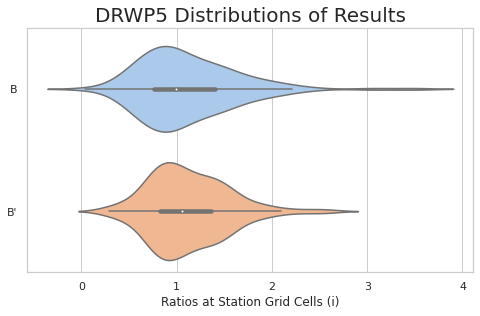

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 49.48321972326574 
UAA_station_mean 29.385 
Combined 39.43410986163287


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: Pa


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)